
The purpose of this notebook is to determine the readability or unreadability of code generated by LLM using another LLM as a Judge / Evaluator.

## Install Dependencies and Import Libraries

In [44]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28'
!pip install mistralai

In [45]:
N_EVAL_SAMPLE_SIZE = 25

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [46]:
import nest_asyncio

nest_asyncio.apply()

In [47]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

from phoenix.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE,
    OpenAIModel,
    MistralAIModel,
    download_benchmark_dataset,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the system consisting of an LLM model which was used to generate implementation code, using an evaluation prompt template against a benchmark dataset of readable and unreadable code with ground-truth labels. For this task we look at the following dataset:

- openai_humaneval_with_readability

In [48]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

Binary Readability Classification Template


In [49]:
print(CODE_READABILITY_PROMPT_TEMPLATE)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{input}
```

Implementation to Evaluate:
```
{output}
```



The template variables are:

- **input:** the query from the user describing the coding task
- **output:** an implementation of the coding task

## Configure the  LLM Judge / Evaluator

Configure your MISTRALAI API key.

In [50]:
if not (mistralai_api_key := os.getenv("MISTRALAI_API_KEY")):
    mistralai_api_key = getpass("🔑 Enter your MISTRALAI API key: ")
os.environ["MISTRALAI_API_KEY"] = mistralai_api_key

Instantiate the LLM Judge / Evaluator and set parameters.


In [51]:
model = MistralAIModel(
    model="codestral-mamba-2407",
    temperature=0.0,
    api_key=mistralai_api_key,
)

Simple test to show that we are able call the model

In [52]:
model("Hello, are you ready to classify code as readable or not?")

"Hello! I'm here to help you with your question. However, I need more information to provide a meaningful response. Could you please provide the code you want to classify as readable or not? Additionally, it would be helpful if you could specify the programming language of the code."

## Sample Benchmark Dataset
Sample size determines run time

In [53]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "input", "solution": "output"},
)



## LLM Code Readability Classifications

Run readability classifications against a subset of the data.

In [12]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=1,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are a stern but practical senior software engineer who cares a lot about simplicity and\nreadability of code. Can you review the following code that was written by another engineer?\nFocus on readability of the code. The implementation is "readable" if you think the code is\nreadable, or "unreadable" if the code is unreadable or needlessly complex for what it\'s trying\nto accomplish.\n\nTask Assignment:\n```\n{input}\n```\n\nImplementation to Evaluate:\n```\n{output}\n```\n\nPlease read the code carefully, then write out in a step by step manner an EXPLANATION to show how\nto evaluate the readability of the code. Avoid simply stating the correct answer at the outset.\nYour response LABEL must be a single word, either "readable" or "unreadable", and should not\ncontain any text or characters aside from that. "readable" means that the code is readable.\n"unreadable" means the code is un

<ipython-input-12-56a93cf1f06c>:5: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications = llm_classify(


llm_classify |          | 0/25 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'readable"' to rail: readable
- Snapped 'unreadable"' to rail: unreadable
- Snapped 'readable"' to rail: readable
- Snapped 'unreadable"' to rail: unreadable
- Snapped 'ed as "readable". The code is simple, well-structured, and easy to understand, making it easy to read and maintain.\n\nLABEL: "readable"' to rail: readable
- Snapped 'readable"\n************' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"' to rail: readable
- Cannot snap 'readable"\n\nExplanation: The implementation is not unreadable, but it may not be the most readable for someone who is not familiar with list comprehensions or the Counter class. The code is clear, concise, and easy to understand, but it may require some explanation to someone who is not familiar with these concepts.' to rails
- Snapped 'readable"' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"\n\nExp


Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       0.50      0.91      0.65        11
  unreadable       0.75      0.21      0.33        14

   micro avg       0.54      0.52      0.53        25
   macro avg       0.62      0.56      0.49        25
weighted avg       0.64      0.52      0.47        25



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

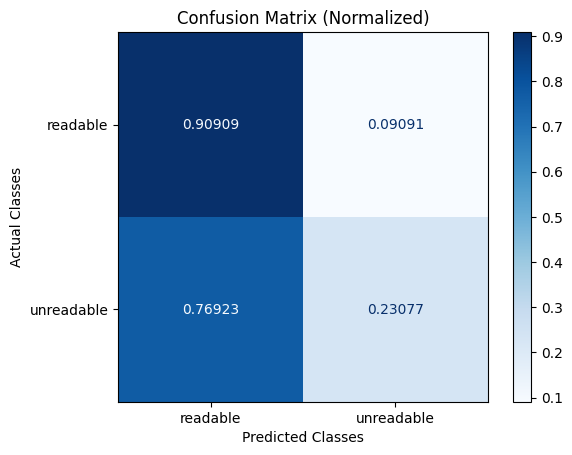

In [13]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [14]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,input,canonical_solution,test,entry_point,readable,output,readability
6,39,HumanEval/39,"\n\ndef prime_fib(n: int):\n """"""\n prime_fib returns n-th number that is a Fibonacci number and it's also prime.\n >>> prime_fib(1)\n 2\n >>> prime_fib(2)\n 3\n >>> prime_fib(3)\n 5\n >>> prime_fib(4)\n 13\n >>> prime_fib(5)\n 89\n """"""\n","import math\n\n def is_prime(p):\n if p < 2:\n return False\n for k in range(2, min(int(math.sqrt(p)) + 1, p - 1)):\n if p % k == 0:\n return False\n return True\n f = [0, 1]\n while True:\n f.append(f[-1] + f[-2])\n if is_prime(f[-1]):\n n -= 1\n if n == 0:\n return f[-1]\n",\n\nMETADATA = {}\n\n\ndef check(candidate):\n assert candidate(1) == 2\n assert candidate(2) == 3\n assert candidate(3) == 5\n assert candidate(4) == 13\n assert candidate(5) == 89\n assert candidate(6) == 233\n assert candidate(7) == 1597\n assert candidate(8) == 28657\n assert candidate(9) == 514229\n assert candidate(10) == 433494437\n\n,prime_fib,False,"import math\ndef is_prime(p):return False if p<2 else all([(p%j)for j in range(2,min(int(math.sqrt(p))+1,p-1))])\nf=[0,1]\nwhile 1:f.append(f[-1]+f[-2]);n-=[is_prime(f[-1])];n or exit(f[-1])",readable
7,80,HumanEval/80,"\ndef is_happy(s):\n """"""You are given a string s.\n Your task is to check if the string is happy or not.\n A string is happy if its length is at least 3 and every 3 consecutive letters are distinct\n For example:\n is_happy(a) => False\n is_happy(aa) => False\n is_happy(abcd) => True\n is_happy(aabb) => False\n is_happy(adb) => True\n is_happy(xyy) => False\n """"""\n",if len(s) < 3:\n return False\n\n for i in range(len(s) - 2):\n \n if s[i] == s[i+1] or s[i+1] == s[i+2] or s[i] == s[i+2]:\n return False\n return True\n,"def check(candidate):\n\n # Check some simple cases\n assert candidate(""a"") == False , ""a""\n assert candidate(""aa"") == False , ""aa""\n assert candidate(""abcd"") == True , ""abcd""\n assert candidate(""aabb"") == False , ""aabb""\n assert candidate(""adb"") == True , ""adb""\n assert candidate(""xyy"") == False , ""xyy""\n assert candidate(""iopaxpoi"") == True , ""iopaxpoi""\n assert candidate(""iopaxioi"") == False , ""iopaxioi""\n",is_happy,False,if(len(s)<3):return False\nfor i in range(len(s)-2):\n if(s[i]==s[i+1]or s[i+1]==s[i+2]or s[i]==s[i+2]):return False\nreturn True,readable
10,44,HumanEval/44,"\n\ndef change_base(x: int, base: int):\n """"""Change numerical base of input number x to base.\n return string representation after the conversion.\n base numbers are less than 10.\n >>> change_base(8, 3)\n '22'\n >>> change_base(8, 2)\n '1000'\n >>> change_base(7, 2)\n '111'\n """"""\n","ret = """"\n while x > 0:\n ret = str(x % base) + ret\n x //= base\n return ret\n","\n\nMETADATA = {}\n\n\ndef check(candidate):\n assert candidate(8, 3) == ""22""\n assert candidate(9, 3) == ""100""\n assert candidate(234, 2) == ""11101010""\n assert candidate(16, 2) == ""10000""\n assert candidate(8, 2) == ""1000""\n assert candidate(7, 2) == ""111""\n for x in range(2, 8):\n assert candidate(x, x + 1) == str(x)\n\n",change_base,False,"rslt = """"\nwhile x > 0:\n rslt = ''.join([str(x % base), rslt])\n x = x // base\nreturn rslt",readable
11,73,HumanEval/73,"\ndef smallest_change(arr):\n """"""\n Given an array arr of integers, find the minimum number of elements that\n need to be changed to make the array palindromic. A palindromic array is an array that\n is read the same backwards and forwards. In one change, you can change one element to any other element.\n\n For example:\n smallest_change([1,2,3,5,4,7,9,6]) == 4\n smallest_change([1, 2, 3, 4, 3, 2, 2]) == 1\n smallest_change([1, 2, 3, 2, 1]) == 0\n """"""\n",ans = 0\n for i in range(len(arr) // 2):\n if arr[i] != arr[len(arr) - i - 1]:\n ans += 1\n return ans\n,"def check(candidate):\n\n # Check some simple cases\n assert candidate([1,2,3,5,4,7,9,6]) == 4\n assert candidate([1, 2, 3, 4, 3, 2, 2]) == 1\n assert candidate([1, 4, 2]) == 1\n assert candidate([1, 4, 4, 

In [14]:
from huggingface_hub import login

# Replace 'your_hf_token' with your actual token
login(token=HF_TOKEN)

In [56]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-large-ntp-py")
gen_model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-large-ntp-py")

In [57]:
index = 1
df.iloc[index]

,1
Unnamed: 0,28
task_id,HumanEval/28
input,"from typing import List\n\n\ndef concatenate(strings: List[str]) -> str:\n """""" Concatenate list of strings into a single string\n >>> concatenate([])\n ''\n >>> concatenate(['a', 'b', 'c'])\n 'abc'\n """"""\n"
canonical_solution,return ''.join(strings)\n
test,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([]) == ''\n assert candidate(['x', 'y', 'z']) == 'xyz'\n assert candidate(['x', 'y', 'z', 'w', 'k']) == 'xyzwk'\n"
entry_point,concatenate
readable,True
output,return ''.join(strings)\n


In [65]:
# Example input prompt
prompt = df["input"].iloc[index]
entry_point = df["entry_point"].iloc[index]
input_text = f"""
You are a Python expert. Here is a task you need to complete:
{prompt}.

Please implement the function named '{entry_point}' and only return the code inside the function named {entry_point}. Remove any other text or explanation.

Make sure to use correct Python syntax.
"""


inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# Generate code
output = gen_model.generate(**inputs, max_length=128)
generated_code = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Code:\n", generated_code)

Generated Code:
 
"""


def concatenate(strings: List[str]) -> str:
    """ Concatenate list of strings into a single string
    >>> concatenate([])
    ''
    >>> concatenate(['a', 'b', 'c'])
    'abc'
    """
    return ''.join(strings)



In [69]:
new_df = df.loc[[index]].copy()
#codet5_df["output"] = {generated_code}
new_df["output"] = generated_code

In [71]:
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=new_df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=1,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are a stern but practical senior software engineer who cares a lot about simplicity and\nreadability of code. Can you review the following code that was written by another engineer?\nFocus on readability of the code. The implementation is "readable" if you think the code is\nreadable, or "unreadable" if the code is unreadable or needlessly complex for what it\'s trying\nto accomplish.\n\nTask Assignment:\n```\n{input}\n```\n\nImplementation to Evaluate:\n```\n{output}\n```\n\nPlease read the code carefully, then write out in a step by step manner an EXPLANATION to show how\nto evaluate the readability of the code. Avoid simply stating the correct answer at the outset.\nYour response LABEL must be a single word, either "readable" or "unreadable", and should not\ncontain any text or characters aside from that. "readable" means that the code is readable.\n"unreadable" means the code is un

<ipython-input-71-28adf4f35a6a>:2: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications = llm_classify(


llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'ed as "readable". The function is simple, straightforward, and well-documented, making it easy to understand and maintain.\n\nLABEL: "readable"' to rail: readable
